# Rebust Url Malware Detection
some explanning

In [1]:
import numpy as np
import seaborn as sns 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
# ------------- Preprocess
from ast import literal_eval # Transform/Parse a string-list into a proper list.
import swifter
import urllib
import re
import math
from pyquery import PyQuery
import requests
import socket
import json
from shodan import Shodan
from whois import whois
from waybackpy import Cdx
from datetime import datetime
import time
import string

In [14]:
df = pd.read_csv("Data/malicious_phish.csv")
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


<AxesSubplot:xlabel='type', ylabel='count'>

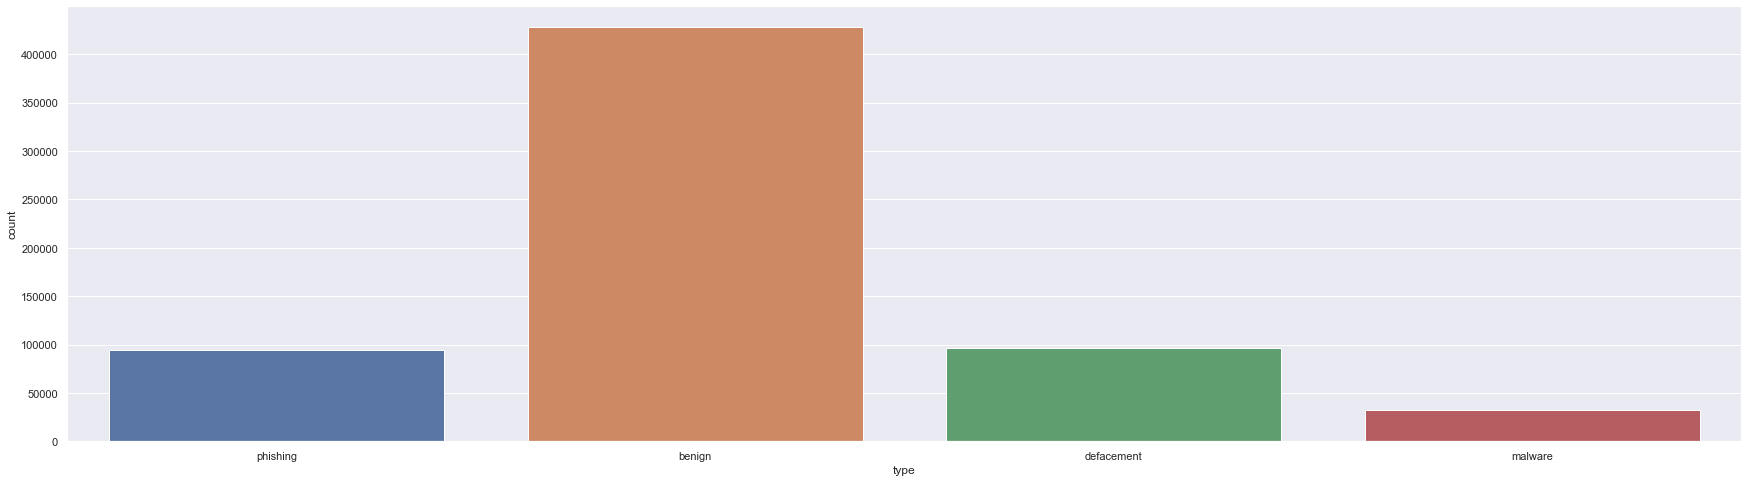

In [3]:
sns.set(rc={'figure.figsize':(30,8)})
sns.countplot(data=df, x='type')

<BarContainer object of 2 artists>

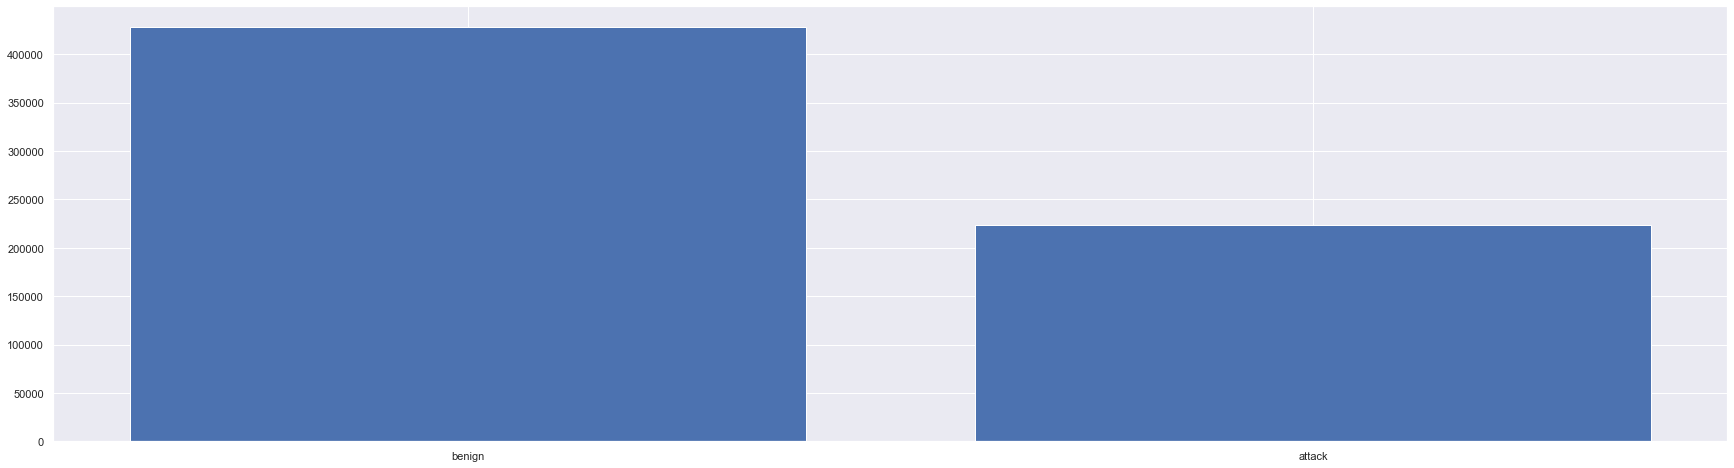

In [4]:
plt.bar(["benign","attack"],[(df['type']=='benign').sum(),(df['type']!='benign').sum()])

In [5]:
df.isna().sum()

url     0
type    0
dtype: int64

In [6]:
df['type'] = pd.Categorical(df['type'])
df['type'] = df['type'].cat.codes
df

,url,type
0,br-icloud.com.br,3
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3
651188,www.gamespot.com/xbox360/action/deadspace/,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3


## Preproccess

In [10]:
def url_host_is_ip(urlparse):
    host = urlparse.netloc
    pattern = re.compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
    match = pattern.match(host)
    return match is not None
    
def get_ip(urlparse):
    try:
        ip = urlparse.netloc if url_host_is_ip() else socket.gethostbyname(urlparse.netloc)
        return ip
    except:
        return None
def url_has_port_in_string(urlparse):
    has_port = urlparse.netloc.split(':')
    return len(has_port) > 1 and has_port[-1].isdigit()

def get_entropy(text):
    text = text.lower()
    probs = [text.count(c) / len(text) for c in set(text)]
    return -sum([p * math.log(p) / math.log(2.0) for p in probs])


In [8]:
defualt_protocol = 'http://'
df['url'] = df['url'].swifter.apply(lambda url : (defualt_protocol+url) if (defualt_protocol not in url) else url)
df

Pandas Apply:   0%|          | 0/651191 [00:00<?, ?it/s]

,url,type
0,http://br-icloud.com.br,3
1,http://mp3raid.com/music/krizz_kaliko.html,0
2,http://bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1
...,...,...
651186,http://xbox360.ign.com/objects/850/850402.html,3
651187,http://games.teamxbox.com/xbox-360/1860/Dead-S...,3
651188,http://www.gamespot.com/xbox360/action/deadspace/,3
651189,http://en.wikipedia.org/wiki/Dead_Space_(video...,3


### Lexical Features: 
These refer to statistical features extracted from the literal URL string. For example, length of the URL string, number of digits, number of parameters in its query part, if the URL is encoded, etc.
see https://towardsdatascience.com/extracting-feature-vectors-from-url-strings-for-malicious-url-detection-cbafc24737a

In [12]:
def get_lexical_url_features(url):
    features = dict()
    try:
        urlparse = urllib.parse.urlparse(url)
        features["url_length"] = len(url)
        features["url_schema"] = urlparse.scheme
        features["url_path_length"] = len(urlparse.path)
        features["url_host_length"] = len(urlparse.netloc)
        features["url_host_is_ip"] = url_host_is_ip(urlparse)
        features['url_has_port_in_string'] = url_has_port_in_string(urlparse)
        features['number_of_digits'] = len([i for i in url if i.isdigit()])
        features['number_of_parameters'] = (0 if urlparse.query == '' else len(urlparse.query.split('&')))
        features['number_of_fragments'] = (len(urlparse.fragment.split('#')) - 1 if urlparse.fragment == '' else 0)
        features['is_encoded'] = '%' in url.lower()
        features['num_encoded_char'] = len([i for i in url if i == '%'])
        features['url_string_entropy'] = get_entropy(url)
        features['number_of_subdirectories'] = len(urlparse.path.split('/'))
        features['number_of_periods'] = len([i for i in url if i == '.'])
        speciel_words = ['client','admin','server','login']
        for word in speciel_words:
            features[f'has_{word}_in_string'] = (word in url.lower())
        features["tld"] = urlparse.netloc.split('.')[-1].split(':')[0]
    except:
        pass
    return pd.Series(features)

features = df['url'].swifter.apply(get_lexical_url_features)

Pandas Apply:   0%|          | 0/651191 [00:00<?, ?it/s]

<ipython-input-12-a5270ed02a70>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(features)


In [16]:
df = pd.concat([df,features],axis=1)
df

,url,type,url_length,url_schema,url_path_length,url_host_length,url_host_is_ip,url_has_port_in_string,number_of_digits,number_of_parameters,...,is_encoded,num_encoded_char,url_string_entropy,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string,tld
0,http://br-icloud.com.br,3,23.0,http,0.0,16.0,False,False,0.0,0.0,...,False,0.0,3.914866,1.0,2.0,False,False,False,False,br
1,http://mp3raid.com/music/krizz_kaliko.html,0,42.0,http,24.0,11.0,False,False,1.0,0.0,...,False,0.0,4.165894,3.0,2.0,False,False,False,False,com
2,http://bopsecrets.org/rexroth/cr/1.htm,0,38.0,http,17.0,14.0,False,False,1.0,0.0,...,False,0.0,3.745465,4.0,2.0,False,False,False,False,org
3,http://www.garage-pirenne.be/index.php?option=...,1,88.0,http,10.0,21.0,False,False,7.0,4.0,...,False,0.0,4.660343,2.0,3.0,False,False,False,False,be
4,http://adventure-nicaragua.net/index.php?optio...,1,235.0,http,10.0,23.0,False,False,22.0,3.0,...,False,0.0,4.980518,2.0,2.0,False,False,False,False,net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,http://xbox360.ign.com/objects/850/850402.html,3,46.0,http,24.0,15.0,False,False,12.0,0.0,...,False,0.0,4.412270,4.0,3.0,False,False,False,False,com
651187,http://games.teamxbox.com/xbox-360/1860/Dead-S...,3,51.0,http,26.0,18.0,False,False,7.0,0.0,...,False,0.0,4.265083,5.0,2.0,False,False,False,False,com
651188,http://www.gamespot.com/xbox360/action/deadspace/,3,49.0,http,26.0,16.0,False,False,3.0,0.0,...,False,0.0,4.216152,5.0,2.0,False,False,False,False,com
651189,http://en.wikipedia.org/wiki/Dead_Space_(video...,3,52.0,http,29.0,16.0,False,False,0.0,0.0,...,False,0.0,4.228722,3.0,2.0,False,False,False,False,org


In [17]:
df.isna().sum()

url                          0
type                         0
url_length                  13
url_schema                  13
url_path_length             13
url_host_length             13
url_host_is_ip              13
url_has_port_in_string      13
number_of_digits            13
number_of_parameters        13
number_of_fragments         13
is_encoded                  13
num_encoded_char            13
url_string_entropy          13
number_of_subdirectories    13
number_of_periods           13
has_client_in_string        13
has_admin_in_string         13
has_server_in_string        13
has_login_in_string         13
tld                         13
dtype: int64

In [18]:
df[df.isna().any(axis=1)]

,url,type,url_length,url_schema,url_path_length,url_host_length,url_host_is_ip,url_has_port_in_string,number_of_digits,number_of_parameters,...,is_encoded,num_encoded_char,url_string_entropy,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string,tld
573431,http://RybjUxÙãl5»7ÆE%ÝÔk+h |U+ýk©ìÉ½Æ...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573461,http://Æe F§÷%¶ ¿Õ½9¿b@Ö¸ÚZE¤ÒC¢ÄÅª2åç-]W...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573462,http://Ó6¸RTÃu~æ Ù g0>÷mÖiÓ=;XZ\%êýÜ...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573467,http://µÔA¨!ÝÛ=]º£¦Pôwr7 2-ÕY5Äòè7¬-³]×=...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573472,"http://¨RÊÃûaCóÞit×ßÂe-DÖØ+9YèÌçÏ¯·""0£ÙÕ....",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573480,http://1]Î¼0#W»æ½Î4>¥õ ª(\xl3(ò5?¹(°åþ¬eéÍû...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573487,http://k¥¤ZM$:)ìLZ£.^rÕÕ{6eZAä¦v·¢ïöè®~QNg...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573488,http://AìfÙêìÝÕ 2£»¸ü9nªÉ®'A½`ymî¹èDéI5...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573496,"http://½<+U ½¹1 [1""Kfw§¿âÎ¸pWb®ÜÜ|¾ Ö...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573498,http://¯=ÓÛ±i-Ð],3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df = df.dropna(axis='index')
df

,url,type,url_length,url_schema,url_path_length,url_host_length,url_host_is_ip,url_has_port_in_string,number_of_digits,number_of_parameters,...,is_encoded,num_encoded_char,url_string_entropy,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string,tld
0,http://br-icloud.com.br,3,23.0,http,0.0,16.0,False,False,0.0,0.0,...,False,0.0,3.914866,1.0,2.0,False,False,False,False,br
1,http://mp3raid.com/music/krizz_kaliko.html,0,42.0,http,24.0,11.0,False,False,1.0,0.0,...,False,0.0,4.165894,3.0,2.0,False,False,False,False,com
2,http://bopsecrets.org/rexroth/cr/1.htm,0,38.0,http,17.0,14.0,False,False,1.0,0.0,...,False,0.0,3.745465,4.0,2.0,False,False,False,False,org
3,http://www.garage-pirenne.be/index.php?option=...,1,88.0,http,10.0,21.0,False,False,7.0,4.0,...,False,0.0,4.660343,2.0,3.0,False,False,False,False,be
4,http://adventure-nicaragua.net/index.php?optio...,1,235.0,http,10.0,23.0,False,False,22.0,3.0,...,False,0.0,4.980518,2.0,2.0,False,False,False,False,net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,http://xbox360.ign.com/objects/850/850402.html,3,46.0,http,24.0,15.0,False,False,12.0,0.0,...,False,0.0,4.412270,4.0,3.0,False,False,False,False,com
651187,http://games.teamxbox.com/xbox-360/1860/Dead-S...,3,51.0,http,26.0,18.0,False,False,7.0,0.0,...,False,0.0,4.265083,5.0,2.0,False,False,False,False,com
651188,http://www.gamespot.com/xbox360/action/deadspace/,3,49.0,http,26.0,16.0,False,False,3.0,0.0,...,False,0.0,4.216152,5.0,2.0,False,False,False,False,com
651189,http://en.wikipedia.org/wiki/Dead_Space_(video...,3,52.0,http,29.0,16.0,False,False,0.0,0.0,...,False,0.0,4.228722,3.0,2.0,False,False,False,False,org


In [20]:
df_small = df.sample(5000)

### Content-Based Features
These are obtained from the downloaded HTML code of the webpage. These features capture the structure of the webpage and the content embedded in it. These will include information on script tags, embedded objects, executables, hidden elements, etc.

In [22]:
def get_html(url):
    try:
        html = requests.get(url, timeout=5)
        html = html.text if html else None
    except:
        html = None
    return html

def get_pq(html):
    try:
        pq = PyQuery(html) if html else None
        return pq
    except:
        return None

def average_script_length(pq):
    scripts_lst = [len(script.text()) for script in pq("script").items()]
    scripts_len = len(scripts_lst)
    return (sum(scripts_lst)/scripts_len) if scripts_len!=0 else 0

def average_number_of_tokens_in_sentence(html):
    sen_lens = [len(i.split()) for i in html.split('.')]
    return sum(sen_lens)/len(sen_lens)

def number_of_included_elements(pq):
    toi = pq('script') + pq('iframe') + pq('frame') + pq('embed') + pq('form') + pq('object')
    toi = [tag.attr('src') for tag in toi.items()]
    return len([i for i in toi if i])


In [ ]:
def get_content_based_features(url):
    features = dict()
    urlparse = urllib.parse.urlparse(url)
    html = get_html(url)
    pq = get_pq(html)
    suspicious_functions = ['escape','eval','link','unescape','exec','search']
#     valid_tags = 
    if not html or not pq:
        features['is_active'] = False
        return pd.Series(features)
    scripts = pq('script')
    features['is_active'] = True
    features['url_page_entropy'] = get_entropy(html)
    features['number_of_script_tags'] = len(scripts)
    features['script_to_body_ratio'] = len(scripts.text())/len(html)
    features['number_of_page_tokens'] = len(html.lower().split())
    features['number_of_sentences'] = len(html.split('.'))
    features['number_of_punctuations'] = len([i for i in html if i in string.punctuation and i not in ['<', '>', '/']])
    features['number_of_distinct_tokens'] = len(set([i.strip() for i in html.lower().split()]))
    features['number_of_capitalizations'] = len([i for i in html if i.isupper()])
    features['number_iframes'] = len(pq('iframe') + pq('frame'))
    features['number_objects'] = len(pq('object'))
    features['number_embeds'] = len(pq('embed'))
    features['number_hyperlinks'] = len(pq('a'))
    features['number_of_whitespace'] = len([i for i in html if i == ' '])
    features['number_of_hidden_tags'] = len(pq('.hidden')+pq('#hidden')+pq('*[visibility="none"]')+pq('*[display="none"]'))
    features['number_of_html_tags'] = len(pq('*'))
    features['number_of_double_documents'] = len(pq('html') + pq('body') + pq('title')) - 3
    for suspicious_func in suspicious_functions:
        features[f'number_of_suspicious_function_{suspicious_func}'] = sum([suspicious_func in script.text().lower() for script in scripts.items()])
    features['average_script_length'] = average_script_length(pq)
#     features['number_of_suspicious_elements'] = len([i for i in [i.tag for i in pq('*')] if i not in valid_tags])#TODO: valid_tags
    features['average_number_of_tokens_in_sentence'] = average_number_of_tokens_in_sentence(html)
    return pd.Series(features)
    
features = df_small['url'].swifter.apply(get_content_based_features)

In [94]:
features

,is_active,url_page_entropy,number_of_script_tags,script_to_body_ratio,number_of_page_tokens,number_of_sentences,number_of_punctuations,number_of_distinct_tokens,number_of_capitalizations,number_iframes,...,number_of_html_tags,number_of_double_documents,number_of_suspicious_function_escape,number_of_suspicious_function_eval,number_of_suspicious_function_link,number_of_suspicious_function_unescape,number_of_suspicious_function_exec,number_of_suspicious_function_search,average_script_length,average_number_of_tokens_in_sentence
0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,5.493346,9.0,0.208203,2054.0,325.0,6444.0,856.0,573.0,3.0,...,506.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,873.888889,7.193846
2,True,4.562782,0.0,0.000000,4000.0,206.0,974.0,1609.0,711.0,0.0,...,167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19.558252
3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,True,5.117157,7.0,0.707511,5106.0,2910.0,69062.0,2347.0,14344.0,0.0,...,1072.0,16.0,0.0,0.0,1.0,0.0,1.0,1.0,26257.285714,2.745361
7,True,5.614912,9.0,0.640216,590.0,297.0,5712.0,442.0,1248.0,0.0,...,144.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1620.777778,2.962963
8,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,True,5.016697,10.0,0.013283,8208.0,7869.0,38583.0,2374.0,2417.0,0.0,...,91.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,315.400000,1.534502


In [88]:
df = pd.concat([df,features],axis=1)
df

,url,type,url
0,br-icloud.com.br,3,{'is_active': False}
1,mp3raid.com/music/krizz_kaliko.html,0,is_active ...
2,bopsecrets.org/rexroth/cr/1.htm,0,is_active ...
3,http://www.garage-pirenne.be/index.php?option=...,1,{'is_active': False}
4,http://adventure-nicaragua.net/index.php?optio...,1,{'is_active': False}
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3,NaN
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,NaN
651188,www.gamespot.com/xbox360/action/deadspace/,3,NaN
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3,NaN


In [ ]:
df = df[df['is_active'] == True]

In [ ]:
df.isna().sum()

In [ ]:
df[df.isna().any(axis=1)].head()

### Host-Based Features
these are characteristics of the host-name properties of the URL. These provide information about the host of the webpage, for example, country of registration, domain name properties, open ports, named servers, connection speed, time to live from registration, etc.

In [96]:
class HostFeatures:
    def __init__(self, url):
        self.url = url
        self.urlparse = urllib.parse.urlparse(self.url)
        self.host = get_ip(urlparse)
        self.now = datetime.now()
        self.whois = self.__get__whois_dict()
        self.shodan = self.__get_shodan_dict()
        self.snapshots = self.__get_site_snapshots()

    def __get__whois_dict(self):
        try:
            whois_dict = whois(self.host)
            return whois_dict
        except:
            return {}

    def __get_shodan_dict(self):
        api = Shodan('W6cy1PGcje0jJwKDBTgrqWSZioRpRmzg')
        try:
            host = api.host(self.host)
            return host
        except:
            return {}


    def __parse_whois_date(self, date_key):
        cdate = self.whois.get(date_key, None)
        if cdate:
            if isinstance(cdate, str) and 'before' in cdate:
                d = datetime.strptime('01-{}'.format(date_string.split()[-1]), '%d-%b-%Y')
            elif isinstance(cdate, list):
                d = cdate[0]
            else:
                d = cdate
        return d if cdate else cdate

    def __get_site_snapshots(self):
        try:
            snapshots = Cdx(self.urlparse.netloc).snapshots()
            snapshots = [snapshot.datetime_timestamp for snapshot in snapshots]
            return snapshots
        except:
            return []


    def number_of_subdomains(self):
        ln1 = self.whois.get('nets', None)
        ln2 = self.shodan.get('domains', None)
        ln = ln1 or ln2
        return len(ln) if ln else None

    def url_creation_date(self):
        return self.__parse_whois_date('creation_date')

    def url_expiration_date(self):
        return self.__parse_whois_date('expiration_date')

    def url_last_updated(self):
        return self.__parse_whois_date('updated_date')

    def url_age(self):
        try:
            days = (self.now - self.url_creation_date()).days
        except:
            days = None
        return days

    def url_intended_life_span(self):
        try:
            lifespan = (self.url_expiration_date() - self.url_creation_date()).days
        except:
            lifespan = None
        return lifespan

    def url_life_remaining(self):
        try:
            rem = (self.url_expiration_date() - self.now).days
        except:
            rem = None
        return rem

    def url_registrar(self):
        return self.whois.get('registrar', None)

    def url_registration_country(self):
        return self.whois.get('country', None)
    def url_host_country(self):
        return self.shodan.get('country_name', None)


    def url_num_open_ports(self):
        return len(self.shodan.get('ports', ''))
        

    def url_isp(self):
        return self.shodan.get('isp', '')

    def url_connection_speed(self):
        return get('{}://{}'.format(self.urlparse.scheme, self.urlparse.netloc)).elapsed.total_seconds()

    def first_seen(self):
        try:
            fs = self.snapshots[0]
            return fs
        except:
            return datetime.now()

    def get_os(self):
        oss = self.shodan.get('os', None)
        return oss

    def last_seen(self):
        try:
            ls = self.snapshots[-1]
            return ls
        except:
            return datetime.now()

    def days_since_last_seen(self):
        return (self.now - self.last_seen()).days

    def days_since_first_seen(self):
        return (self.now - self.first_seen()).days

    def average_update_frequency(self):
        snapshots = self.snapshots
        diffs = [(t-s).days for s, t in zip(snapshots, snapshots[1:])]
        l = len(diffs)
        if l > 0:
            return sum(diffs)/l
        else:
            return 0

    def number_of_updates(self):
        return len(self.snapshots)

    def ttl_from_registration(self):
        try:
            ttl_from_reg = (self.first_seen() - self.url_creation_date()).days
        except:
            ttl_from_reg = None
        return ttl_from_reg

In [ ]:
def get_host_based_features(url):
    features = dict()
    features_extractor = HostFeatures(url)
    features['ttl_from_registration'] = features_extractor.ttl_from_registration()
    features['average_update_frequency'] = features_extractor.average_update_frequency()
    features['days_since_first_seen'] = features_extractor.days_since_last_seen()
    features['days_since_last_seen'] = features_extractore.days_since_last_seen()
    features['last_seen'] = features_extractor.last_seen()
    
    features['get_os'] = features_extractor.get_os()
    features['url_registrar'] = features_extractor.url_registrar()
    features['first_seen'] = features_extractor.first_seen()
    features['url_connection_speed'] = features_extractor.url_connection_speed()
    features['url_isp'] = features_extractor.url_isp()
    features['url_num_open_ports'] = features_extractor.url_num_open_ports()
    features['url_host_country'] = features_extractor.url_host_country()
    features['number_of_updates'] = features_extractor.number_of_updates()
    features['url_life_remaining'] = features_extractor.url_life_remaining()
    features['url_intended_life_span'] = features_extractor.url_intended_life_span()
    features['url_age'] = features_extractor.url_age()
    features['url_last_updated'] = features_extractor.url_last_updated()
    features['number_of_subdomains'] = features_extractor.number_of_subdomains()
    features['url_creation_date'] = features_extractor.url_creation_date()
    features['url_expiration_date'] = features_extractor.url_expiration_date()
    
    return pd.Series(features)
    
features = df['url'].swifter.apply(get_host_based_features)

In [ ]:
features

In [ ]:
df = pd.concat([df,features],axis=1)
df

## Models

In [26]:
sns.heatmap(df.corr(), cmap='Blues')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2,  random_state=42)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

In [ ]:
pca = PCA(n_components=0.99)
pca_X = pca.fit_transform(X_train)
pca_X

In [ ]:
import xgboost as xgb
def xgboost_pipeline(x_train, y_train, x_test,num_round=1000,thr=0.5):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,random_state=1)
    param = {"learning_rate": 0.05, "max_depth": 8, "min_child_weight": 1, "gamma": 0, "subsample": 0.7,
             "objective": 'binary:logistic', "scale_pos_weight": 1, "seed": 93, "eval_metric": "logloss"}
    # "colsample_bytree":0.8# evals=evals, early_stopping_rounds=10
    d_train = xgb.DMatrix(x_train, label=y_train)
    d_eval = xgb.DMatrix(x_val, label=y_val)
    evallist = [(d_eval, 'eval'), (d_train, 'train')]
    bst = xgb.train(param, d_train, num_round, evallist)
    d_test = xgb.DMatrix(x_test)
    xgboost_pred = bst.predict(d_test)
    xgboost_pred[xgboost_pred > thr] = 1
    xgboost_pred[xgboost_pred <= thr] = 0
    return xgboost_pred,bst

In [ ]:
xgboost_pred,bst_binary = xgboost_pipeline(X_train,y_train,X_test)
print(classification_report(y_test, xgboost_pred))

In [ ]:
clf = RandomForestClassifier(max_depth=8, random_state=0,)
clf.fit(X_train, y_train)
clf_prediction = clf.predict(X_test)
print(classification_report(y_test, clf_prediction))

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
print(classification_report(y_test,pred))

## Deep Learrning Based Bag-Of-Characters

In [15]:
df = df.sample(10000)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=0.01,token_pattern='.')#max_features=1000
X_counts = count_vect.fit_transform(df['url'])
X_counts

<10000x48 sparse matrix of type '<class 'numpy.int64'>'
	with 223298 stored elements in Compressed Sparse Row format>

In [19]:
count_vect_df = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names())
count_vect_df

,%,&,+,-,.,/,0,1,2,3,...,r,s,t,u,v,w,x,y,z,~
0,0,0,0,7,1,5,2,2,2,0,...,4,1,0,3,0,2,0,1,0,0
1,0,0,0,6,4,6,1,0,0,1,...,6,0,8,3,1,3,0,3,0,0
2,0,3,0,0,3,3,0,1,0,1,...,3,1,7,0,1,4,1,0,0,0
3,0,0,0,1,2,1,0,0,0,0,...,2,0,2,1,0,0,0,2,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,1,0,1,2,0,0,0,0,...,2,1,1,0,0,1,0,1,0,0
9996,0,4,0,0,3,3,0,0,0,0,...,5,2,8,2,1,1,1,1,0,0
9997,0,0,0,0,2,2,0,0,0,0,...,0,2,3,0,0,3,0,0,0,0
9998,0,0,0,0,2,2,0,0,0,0,...,1,2,1,1,0,3,0,0,0,0


https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()


In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

In [ ]:
test_loop(test_dataloader, model, loss_fn)